# DCGAN  using Pytorch
### We will be generating new faces using DCGAN.
#### I have broken down my code into small parts for better understanding.
For more information please refer to https://arxiv.org/pdf/1511.06434.pdf

## Installing Pytorch

In [1]:
!pip3 install torch torchvision torchaudio

## Installing libraries

In [2]:
# Data processing
import numpy as np
import pandas as pd

# Pytorch
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils

# Visualization
import matplotlib.pyplot as plt

## Setting up required variables
We require only one variable and that is for our images directory.

In [3]:
rooty = "/kaggle/input/celeba-dataset/img_align_celeba/"

## Loading dataset
We wil be applying transformation at the same time of importing dataset.

**Note** - We could also have used MNIST instead of Celeb Face dataset.

In [4]:
dataset = dset.ImageFolder(root=rooty,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

#### As the original dataset contains too many images, we will only be using 60,000 images

In [5]:
need_length = 60000
waste = 142599
main_dataset,test_dataset=torch.utils.data.random_split(dataset,(need_length,waste))

## Instantiating dataloader

In [6]:
dataloader = torch.utils.data.DataLoader(main_dataset, batch_size=128,
                                         shuffle=True, num_workers=2)

## Visualizing images

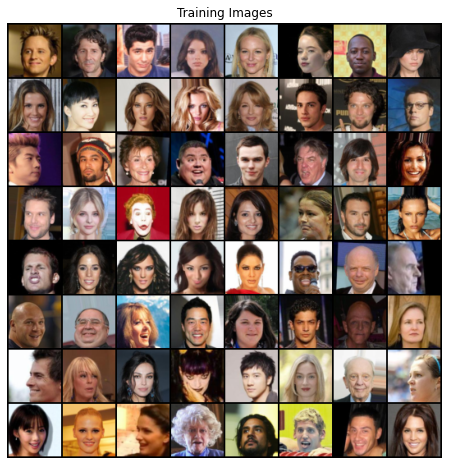

In [7]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(),(1,2,0)))

## Creating Discriminator

In [8]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d*2, 4, 2, 1),
            self._block(features_d*2, features_d*4, 4, 2, 1),
            self._block(features_d*4, features_d*8, 4, 2, 1),
            nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid()

            )
        
        
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        
        )
    
    def forward(self, x):
        return self.disc(x)

## Creating Generator

In [9]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            self._block(z_dim, features_g*16, 4, 1, 0),
            self._block(features_g*16,features_g*8, 4, 2, 1),
            self._block(features_g*8, features_g*4, 4, 2, 1),
            self._block(features_g*4, features_g*2, 4, 2, 1),
            nn.ConvTranspose2d(features_g*2, channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
                    
        )
        
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            
        
        )
    
    def forward(self, x):
        return self.gen(x)           

### Initializing weights as mentioned in the paper

In [10]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d )):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

## Setting up the hyperparameters

Please keep in mind that GANs are highly sensitive to hyperparameters.

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 2e-4
IMAGE_SIZE = 64
CHANNELS_IMG = 3
Z_DIM = 100
NUM_EPOCHS = 10
FEATURES_DISC = 64
FEATURES_GEN = 64

In [12]:
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

## Optimizer
### Values have been applied according to the paper https://arxiv.org/pdf/1511.06434.pdf

In [13]:
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

## Loss function
This loss is very similar to the one mentioned in the paper and works well for our cause here. 

In [14]:
criterion = nn.BCELoss()

In [15]:
gen.train()
disc.train()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
    (6): Sigmoid()
  )
)

## Training loop

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fixed_noise = torch.randn(64, 100, 1, 1, device=device)
img_list = []
iters = 0

for epochs in range(NUM_EPOCHS):
    tld = 0
    tlg = 0
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)
        noise = torch.randn((128, Z_DIM, 1, 1)).to(device)
        fake = gen(noise)
        
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward(retain_graph=True)
        opt_disc.step()
        
        tld += loss_disc.item()
        
        
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()
        
        tlg += loss_gen.item()
        
        
        if (iters % 500 == 0) or ((epochs == NUM_EPOCHS-1) ):
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
        
    print("Epoch no: ", epochs, " Discriminator Loss: ", tld, " Generator Loss: ", tlg )

Epoch no:  0  Discriminator Loss:  210.09545112773776  Generator Loss:  944.9519006758928
Epoch no:  1  Discriminator Loss:  273.5962014198303  Generator Loss:  783.229171693325
Epoch no:  2  Discriminator Loss:  263.7463725209236  Generator Loss:  839.801590025425
Epoch no:  3  Discriminator Loss:  254.29412788152695  Generator Loss:  864.5769183039665
Epoch no:  4  Discriminator Loss:  239.61614573001862  Generator Loss:  903.8371499180794
Epoch no:  5  Discriminator Loss:  236.88406226038933  Generator Loss:  868.525713711977
Epoch no:  6  Discriminator Loss:  236.85124230384827  Generator Loss:  825.9967409968376
Epoch no:  7  Discriminator Loss:  235.34955206513405  Generator Loss:  789.2325383424759
Epoch no:  8  Discriminator Loss:  236.23642095923424  Generator Loss:  773.4493708610535
Epoch no:  9  Discriminator Loss:  236.95660337805748  Generator Loss:  758.0082045942545


## Fake images
### Here we are looking at some of the fake images that our DCGAN was able to produce.

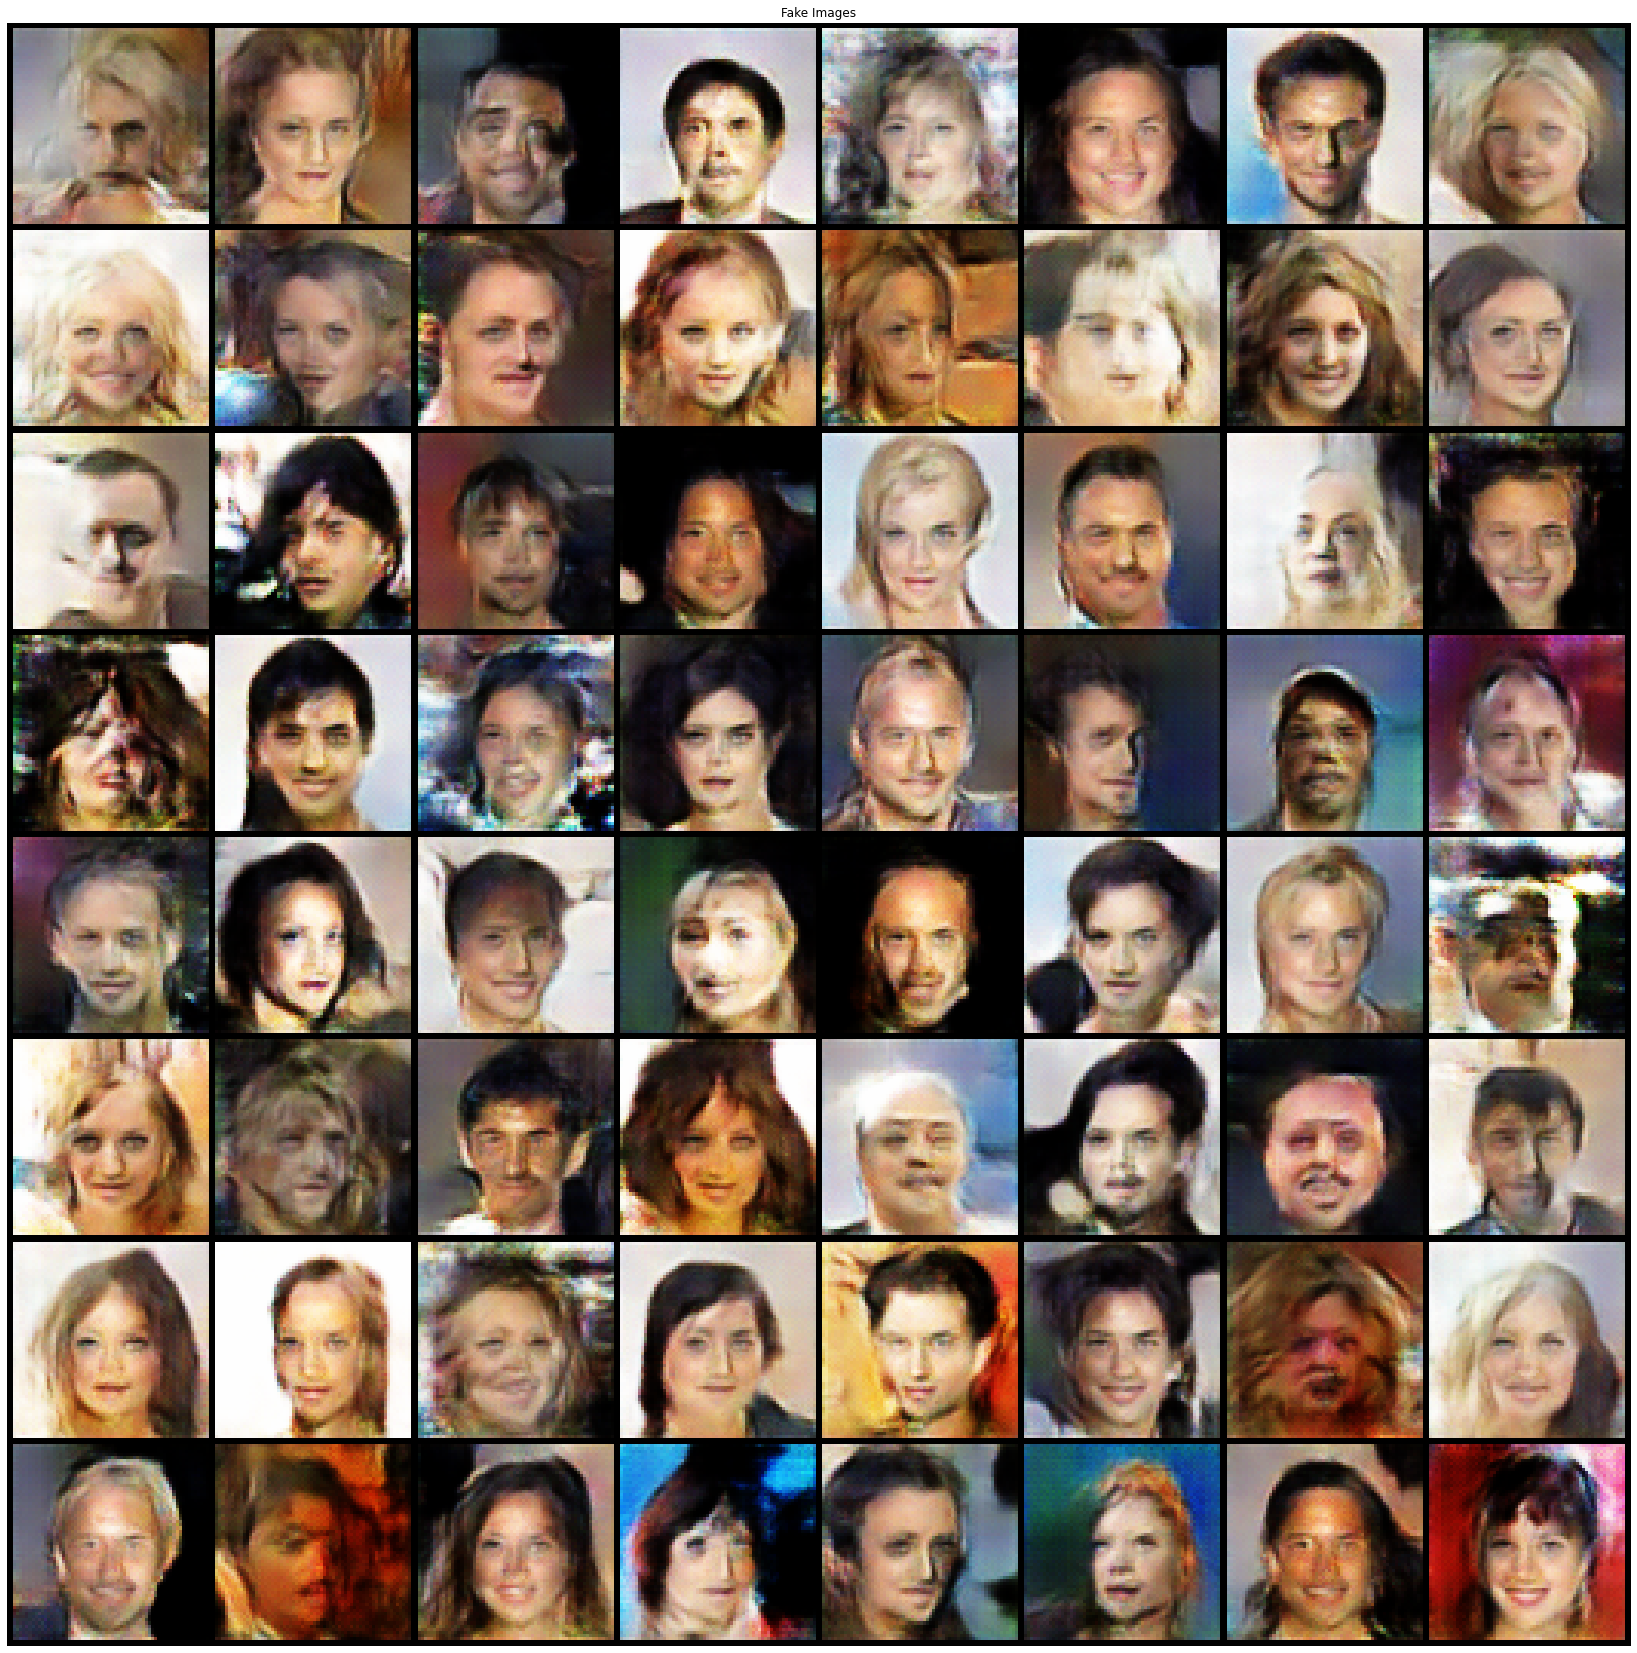

In [17]:
plt.figure(figsize=(64,64))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()


### The end